In [1]:
import sys
sys.path.append('../')

import graph.random_graph as random_graph
import util.create_population as create_population
import core_nn.fit_model as fit_model

import torch
import pandas as pd
import random
from matplotlib import pyplot as plt
import networkx as nx
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
class EPI_dense2(torch.nn.Module):
    def __init__(self, ISNet, psMatrix, device, train=False, cc=None, recursive=False, sampleAsState=True):
        super(EPI_dense2, self).__init__()
        self._n= ISNet.size()[0]
        self._IS= ISNet
        self._EE= torch.eye(self._n).to(device)
        self._II= self._EE
        self._RR= self._EE
        #self._state= torch.stack((population["S"], population["E"], population["I"], population["R"]))
        self._psMatrix= psMatrix
        self._train= train
        if train==True:
            self._psMatrix=torch.nn.Parameter(psMatrix)
        self._P= None
        self._forceCc=torch.tensor([[0, 1, 0, 0],
                                    [0, 0, 1, 0],
                                    [0, 0, 0, 1],
                                    [0, 0, 0, 0]], device=device) 
        self._cc= cc
        self._recursive= recursive
        self._softmaxLayer= torch.nn.Softmax(dim=1)
        self._sampleAsState= sampleAsState
        self.inference= False
    
    def reset_probability(self, population):
        #self._state= torch.stack((population["S"], population["E"], population["I"], population["R"]))
        self._P= None

    def forward(self, state, inference=False):
        if self._train==False:
            psMatrix= self._psMatrix
        else:
            psMatrix= self.get_psMatrix()
        L= torch.zeros_like(state, device=device)
        #logBase= torch.log(1-psMatrix[0, 1])
        #st2= state[2][None, :]
        #st0= state[0][:, None]
        #tempL0= torch.log(1-self._IS*st0*st2*psMatrix[0, 1])
        #L[0]= tempL0.sum(dim=1)/logBase
        #print((L[0]-state[0]*torch.matmul(self._IS, state[2])).sum())

        L[:, 0]= state[:, 0]*torch.matmul(self._IS, state[:, 2].T).T
        L[:, 1]= torch.matmul(state[:, 1], self._EE)
        L[:, 2]= torch.matmul(state[:, 2], self._II)
        L[:, 3]= torch.matmul(state[:, 3], self._RR)
        prob= 1- torch.exp(torch.matmul(torch.log(1 - psMatrix.T), L))
        
        _stable_prob= 1- torch.sum(prob, 1)
        
        #torch.Size([5, 4, 1000])
        #torch.Size([5, 4, 1000])
        #torch.Size([5, 1000])
        _stable_prob= _stable_prob[:, None]
        prob= prob+ state*_stable_prob
        self._P= prob

        if self._sampleAsState:
            stateReturn= self.sample_uniform_matrix(prob)
            if self._train and self._recursive and self.inference==False:
                stateReturn= 0.9*stateReturn+0.1*prob#gradient disappearing here, consider only transfer probability?
        else:
            stateReturn= prob  

        return stateReturn, prob
        #return torch.sum(self._state, 1), torch.sum(prob, 1), prob
    
    def get_population_num(self, state):

        return torch.sum(state, 2)

    #sample nxm pobability matrix, of 0 dimension, which contains n choise for a random variable
    def sample_uniform_matrix(self, P):  
        state= torch.zeros_like(P, device=device)
        U= torch.rand(self._n).to(device)
        for i in range(P.size()[1]):
            U= U- P[:, i]
            state[:, i]= U<0
            U= U+state[:, i]
        return state
    
    def get_population_dir(self, state):
        return { #a columnar DB somewhat reminds the Pandas DataFrame 
                "S": state[0],
                "E": state[1],
                "I": state[2],
                "R": state[3],
                }
    
    def get_probability(self):
        return self._P
    
    def get_probability_transition_matrix(self):
        
        return self._psMatrix
    
    def get_psMatrix(self):
        #psMatrix= torch.sigmoid(self._psMatrix)
        psMatrix= self._softmaxLayer(self._psMatrix)
        psMatrix= psMatrix*self._forceCc
        if self._cc is not None:
                psMatrix= psMatrix*self._cc
        return psMatrix

In [3]:
def sim(timeHorizon, model: EPI_dense2, state):
  populationNumber= []
  states = [state]
  for _ in range(timeHorizon):
    state, _= model(state)
    populationNumber.append(model.get_population_num(state))
    states.append(state)
  populationNumber = torch.stack(populationNumber)
  states = torch.stack(states)
  return populationNumber, states

In [139]:
n= 3000
avgDegree= 6
timeHorizon= 100
print("haha")
contact=random_graph.get_ER_random_contact(n, avgDegree, device=device)
print("haha")
contact = contact.requires_grad_(True)
realData =None
with torch.no_grad():
    ps= torch.tensor([[0, 0.08, 0, 0],
                      [0, 0, 0.5, 0],
                      [0, 0, 0, 0.08],
                      [0, 0, 0, 0]], device=device)
    state= create_population.population(n, device)
    state= state[None, :]#state: 1x4x100, for minibatch
    model= EPI_dense2(contact, ps, device, sampleAsState=True)
    realData, _ =sim(timeHorizon, model, state)
realData= realData.squeeze()

haha
haha


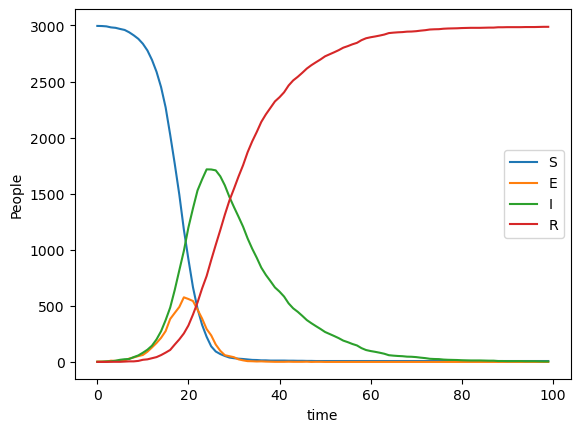

In [140]:
populationNumberPlot= realData.cpu().detach()
plt.plot(populationNumberPlot, label=['S', 'E', 'I', 'R'])
plt.xlabel("time")
plt.ylabel("People")
plt.legend()

In [133]:
windowSize= 10
batchSize= 80
realData.requires_grad_(True)
psFit= torch.tensor([[0, 0, 0, 0],
                     [0, 0, 0.0, 0],
                     [0, 0, 0, 0.0],
                     [0.0, 0, 0, 0]], device=device)
cc= torch.tensor([  [0, 1, 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1],
                    [0, 0, 0, 0]], device=device)
modelFit= EPI_dense2(contact, psFit, device, train=True, cc=cc, recursive=True)
lossFn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(modelFit.parameters(), lr=1e-2)
#generate dataset
def generate_dateset(model: EPI_dense2, ys, timeHorizon=100, windowSize= 5):
    stateZero = create_population.population(n, device)
    stateZero= stateZero[None, :]
    model.inference= True
    
    _, states= sim(timeHorizon-windowSize-1, model, stateZero)#generate data more times?

    states= states.squeeze()
    infectiveNum=[]
    for i in range(timeHorizon-windowSize):
        infectiveNum.append(ys[i: i+windowSize])
    infectiveNum= torch.stack(infectiveNum)
    model.inference= False
    dataset = torch.utils.data.TensorDataset(states, infectiveNum)
    return dataset, states

In [134]:
losses= []

for i in tqdm(range(200)):
    optimizer.zero_grad()
    dataset, states= generate_dateset(modelFit, realData[ :, 2], timeHorizon, windowSize= windowSize)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle = True)
    for batch in dataloader:
        fitY= []
        x, y = batch
        for j in range(windowSize):
            out1, _ = modelFit(x)
            fitY.append(model.get_population_num(out1))
            x= out1
        y= y.T
        fitY= torch.stack(fitY)
        loss= lossFn(fitY[:, :, 2], y)/n/windowSize
        losses.append(loss.item())
        loss.backward(retain_graph=True)
        optimizer.step()
        break

100%|██████████| 200/200 [00:30<00:00,  6.62it/s]


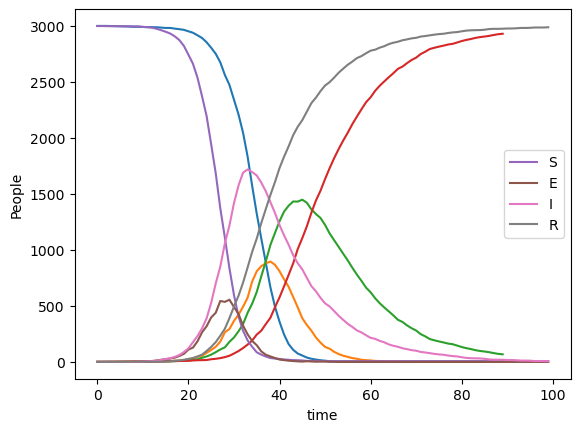

In [135]:

#print(x.shape)
plotStates= states.cpu().detach()
plotStates= plotStates.sum(dim=2)

plt.plot(plotStates)
plt.plot(populationNumberPlot, label=['S', 'E', 'I', 'R'])
plt.xlabel("time")
plt.ylabel("People")
plt.legend()

tensor([[0.0000, 0.1016, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2269, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0798],
        [0.0000, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<MulBackward0>)
None
4879.90185546875


/tmp/ipykernel_7394/2677378229.py:2: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1670027390539/work/build/aten/src/ATen/core/TensorBody.h:480.)
  print(loss.grad)


Text(0, 0.5, 'loss')

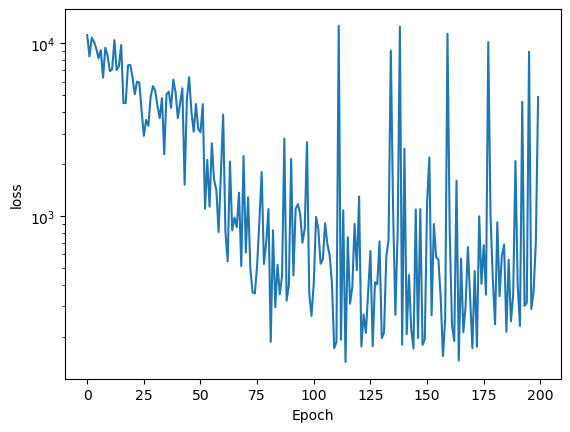

In [136]:
print(modelFit.get_psMatrix())
print(loss.grad)
print(loss.item())
plt.plot(losses)
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("loss")

In [131]:
def print_model_parameters(model):
    for name, parameter in model.named_parameters():
        print('name           : {}'.format(name))
        print('parameter      : {}'.format(parameter))
        print('learnable      : {}'.format(parameter.requires_grad))
        print('parameter.shape: {}'.format(parameter.shape))
        print('parameter.grad: {}'.format(parameter.grad))
        print('---------------------------------')
print_model_parameters(modelFit)

name           : _psMatrix
parameter      : Parameter containing:
tensor([[ 0.5166, -0.5166,  0.5166,  0.5166],
        [ 0.1237,  0.1237, -0.1237,  0.1237],
        [ 0.6910,  0.6910,  0.6910, -0.6910],
        [ 0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0',
       requires_grad=True)
learnable      : True
parameter.shape: torch.Size([4, 4])
parameter.grad: tensor([[  0.0211,  -0.0634,   0.0211,   0.0211],
        [  4.7250,   4.7250, -14.1751,   4.7250],
        [ -2.4321,  -2.4321,  -2.4321,   7.2964],
        [  0.0000,   0.0000,   0.0000,   0.0000]], device='cuda:0')
---------------------------------


In [142]:
populationNumberPlot2= fitPopulation.cpu().detach()
plt.plot(populationNumberPlot2, label=['S', 'E', 'I', 'R'])
plt.plot(populationNumberPlot, label=['So', 'Eo', 'Io', 'Ro'])
plt.xlabel("time")
plt.ylabel("people")
plt.legend()

NameError: name 'fitPopulation' is not defined